Course Page: <https://karpathy.ai/zero-to-hero.html>
{{< video https://www.youtube.com/watch?v=q8SA3rM6ckI >}}

## Setup

In [ ]:
# there no change change in the first several cells from last lecture

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# ok biolerplate done, now we get to the action:

In [ ]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff} | shapes: {dt.shape} vs. {t.shape}')

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters_named = dict(
  C=C,
  W1=W1,
  b1=b1,
  W2=W2,
  b2=b2,
  bngain=bngain,
  bnbias=bnbias,
)
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [ ]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [ ]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3390, grad_fn=<NegBackward0>)

## Backprop through the atomic compute graph

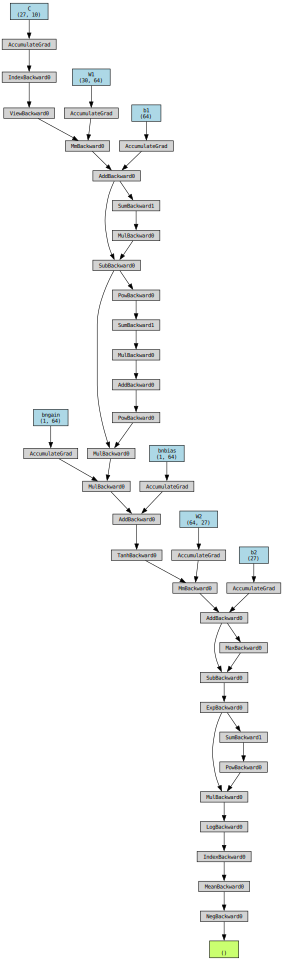

In [ ]:
from torchviz import make_dot

make_dot(loss, params=parameters_named)

In [ ]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
# get all rows, and index into the correct column for the labels
dlogprobs[range(n), Yb] = -1/n
dprobs = dlogprobs * 1 / probs
dcounts_sum_inv = (dprobs * counts).sum(1, keepdim=True)
dcounts_sum = dcounts_sum_inv * -counts_sum**-2
dcounts = counts_sum_inv * dprobs
# gradients flow through other vertex!
dcounts += dcounts_sum * 1

dnorm_logits = dcounts * norm_logits.exp()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
    
dlogits = dnorm_logits.clone() 
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dh = dlogits @ W2.T

dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

dhpreact = dh * (1 - h**2)

dbngain = (dhpreact * bnraw).sum(0, keepdim=True)
dbnbias = dhpreact.sum(0, keepdim=True)
dbnraw = dhpreact * bngain

dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar = dbnvar_inv * -.5 * (bnvar + 1e-5)**-1.5

dbndiff2 = torch.ones_like(bndiff2) * 1 / (n-1) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()

dbnmeani = (-dbndiff).sum(0, keepdim=True)
dhprebn += dbnmeani * torch.ones_like(hprebn) * 1 / n

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = torch.ones_like(emb) * dembcat.view(n, 3, -1) 

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0 | shapes: torch.Size([32, 27]) vs. torch.Size([32, 27])
probs           | exact: True  | approximate: True  | maxdiff: 0.0 | shapes: torch.Size([32, 27]) vs. torch.Size([32, 27])
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0 | shapes: torch.Size([32, 1]) vs. torch.Size([32, 1])
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0 | shapes: torch.Size([32, 1]) vs. torch.Size([32, 1])
counts          | exact: True  | approximate: True  | maxdiff: 0.0 | shapes: torch.Size([32, 27]) vs. torch.Size([32, 27])
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0 | shapes: torch.Size([32, 27]) vs. torch.Size([32, 27])
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0 | shapes: torch.Size([32, 1]) vs. torch.Size([32, 1])
logits          | exact: True  | approximate: True  | maxdiff: 0.0 | shapes: torch.Size([32, 27]) vs. torch.Size([32, 27])
h               | exac

## Backprop through cross-entropy in one go


### Computation graph

## Backprop through Batchnorm in one go


### Computation graph

### Forward Pass Equations

given:
$$
    \displaylines{\mu = \frac{1}{n}\sum_{i}^{n}x_i \\
    \sigma^2 = \frac{1}{n-1}\sum_{i}^{n}(x_i - \mu)^2
    }
$$


::: {.aside} 
(note [Bessel's
correction](https://en.wikipedia.org/wiki/Bessel%27s_correction)) 
:::



then:
$$
    \hat{x_i} = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} \
$$
and finally:
$$y_i = \gamma \hat{x_i} + \beta$$


### Backward Pass Derivation